In [ ]:
print("Hello World!")

#1 Operaciones Morfologicas

In [ ]:
%pip install ipywidgets

In [ ]:
%pip uninstall opencv-python opencv-python-headless -y

In [ ]:
%pip install opencv-python

In [ ]:
%pip install numpy

In [15]:
import cv2
import numpy as np

# Inicializar la captura de video desde la webcam (índice 0)
cap = cv2.VideoCapture(0)

# Definir el kernel
kernel = np.ones((5, 5), np.uint8)

# Crear una ventana de visualización
cv2.namedWindow('Estilizado en Tiempo Real', cv2.WINDOW_NORMAL)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    smoothed = cv2.bilateralFilter(frame, d=9, sigmaColor=75, sigmaSpace=75)

    # Redimensionar el marco para procesamiento más rápido
    frame = cv2.resize(frame, (640, 480))

    # Convertir a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Aplicar cierre
    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

    # Aplicar apertura
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    # Aplicar binarización
    _, binary = cv2.threshold(opened, 120, 255, cv2.THRESH_BINARY_INV)

    # Calcular el gradiente morfológico
    gradient = cv2.morphologyEx(opened, cv2.MORPH_GRADIENT, kernel)

    # Invertir el gradiente para obtener bordes en blanco sobre fondo negro
    gradient_inv = cv2.bitwise_not(gradient)

    # Convertir el gradiente a tres canales
    gradient_colored = cv2.cvtColor(gradient_inv, cv2.COLOR_GRAY2BGR)

    # Aplicar el efecto de dibujo
    styled_frame = cv2.bitwise_and(smoothed, gradient_colored)

    # Mostrar el fotograma en proceso
    cv2.imshow('Estilizado en Tiempo Real', styled_frame)

    # Romper el ciclo con 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar recursos
cap.release()
cv2.destroyAllWindows()

#Metrica de Operaciones Morfologicas

100%|██████████| 12/12 [00:01<00:00,  7.88it/s]



Métrica de Cartoon-ness: 2.85%
Máximo Cartoon-ness observado: 9.44%
Imagen con máximo Cartoon-ness: bird.png


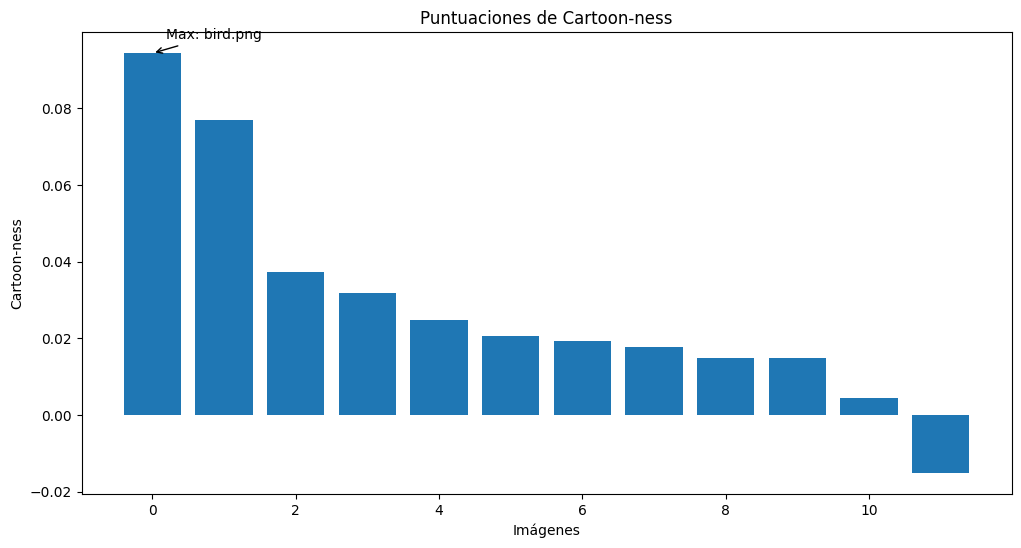

In [10]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt
from datetime import datetime

def calculate_cartoon_ness(image):
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicar suavizado bilateral
    smoothed = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    
    # Definir el kernel para operaciones morfológicas
    kernel = np.ones((5, 5), np.uint8)
    
    # Aplicar cierre y apertura
    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    # Binarización
    _, binary = cv2.threshold(opened, 120, 255, cv2.THRESH_BINARY_INV)
    
    # Calcular el gradiente morfológico
    gradient = cv2.morphologyEx(opened, cv2.MORPH_GRADIENT, kernel)
    
    # Simplicidad de bordes
    edge_length = np.sum(gradient > 0)
    max_possible_edge_length = gradient.shape[0] * gradient.shape[1]
    edge_simplicity = 1 - (edge_length / max_possible_edge_length)
    
    # Homogeneidad de regiones
    _, labels, stats, _ = cv2.connectedComponentsWithStats(binary)
    region_variances = []
    for label in range(1, stats.shape[0]):
        region = smoothed[labels == label]
        if len(region) > 0:
            region_variances.append(np.var(region))
    avg_region_variance = np.mean(region_variances) if region_variances else 0
    region_homogeneity = 1 / (1 + avg_region_variance)
    
    # Contraste de bordes
    edge_mask = gradient > 0
    edge_contrast = np.mean(smoothed[edge_mask]) - np.mean(smoothed[~edge_mask])
    max_possible_contrast = 255
    normalized_edge_contrast = edge_contrast / max_possible_contrast
    
    # Cálculo final de cartoon-ness
    cartoon_ness = (0.4 * edge_simplicity + 
                    0.3 * region_homogeneity + 
                    0.3 * normalized_edge_contrast)
    
    return cartoon_ness

# Obtener la ruta de la carpeta actual
dataset_dir = os.path.join(os.getcwd(), "imgs")

# Crear una carpeta para los resultados
results_dir = "resultados_cartoon_ness"
os.makedirs(results_dir, exist_ok=True)

# Generar un nombre de archivo único basado en la fecha y hora actual
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = os.path.join(results_dir, f"resultados_cartoon_ness_{timestamp}.csv")
plot_filename = os.path.join(results_dir, f"grafico_cartoon_ness_{timestamp}.png")

# Lista para almacenar los resultados
results = []

# Iterar sobre todas las imágenes en el directorio
for filename in tqdm(os.listdir(dataset_dir)):
    if filename.endswith((".png", ".jpg", ".jpeg",".webp")):
        image_path = os.path.join(dataset_dir, filename)
        image = cv2.imread(image_path)
        
        if image is not None:
            cartoon_ness = calculate_cartoon_ness(image)
            results.append((filename, cartoon_ness))

# Ordenar los resultados por cartoon-ness (de mayor a menor)
results.sort(key=lambda x: x[1], reverse=True)

# Guardar los resultados en un archivo CSV
with open(csv_filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Filename', 'Cartoon-ness'])  # Encabezados
    for filename, score in results:
        csvwriter.writerow([filename, f"{score:.4f}"])

# Después de procesar todas las imágenes y antes de ordenar los resultados
max_cartoon_ness = max(results, key=lambda x: x[1])
max_cartoon_ness_filename, max_cartoon_ness_score = max_cartoon_ness

# Calcular la métrica única
scores = [score for _, score in results]
cartoon_ness_metric = np.mean([score for _, score in results])
cartoon_ness_percentage = cartoon_ness_metric * 100
max_observed_cartoon_ness = max_cartoon_ness_score * 100

# Añadir la métrica única, el máximo observado y la imagen correspondiente al CSV y al output
with open(csv_filename, 'a', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Métrica de Cartoon-ness (%)', f"{cartoon_ness_percentage:.2f}%"])
    csvwriter.writerow(['Máximo Cartoon-ness observado (%)', f"{max_observed_cartoon_ness:.2f}%"])
    csvwriter.writerow(['Imagen con máximo Cartoon-ness', max_cartoon_ness_filename])

print(f"\nMétrica de Cartoon-ness: {cartoon_ness_percentage:.2f}%")
print(f"Máximo Cartoon-ness observado: {max_observed_cartoon_ness:.2f}%")
print(f"Imagen con máximo Cartoon-ness: {max_cartoon_ness_filename}")

# Si quieres mostrar esta imagen en el gráfico
plt.figure(figsize=(12, 6))
plt.bar(range(len(scores)), scores)
plt.title('Puntuaciones de Cartoon-ness')
plt.xlabel('Imágenes')
plt.ylabel('Cartoon-ness')
plt.annotate(f'Max: {max_cartoon_ness_filename}',
            xy=(results.index(max_cartoon_ness), max_cartoon_ness_score),
            xytext=(10, 10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))
plt.savefig(plot_filename)

#2 Yolo

In [ ]:
%pip install ultralytics

In [ ]:
# Instalar 
%pip install matplotlib

In [16]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov5s.pt") 

# Iniciar la captura de video
cap = cv2.VideoCapture(0)

# Comprobar si la cámara está abierta
if not cap.isOpened():
    print("Error: No se pudo abrir la cámara.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Realizar la detección de objetos
    results = model(frame)
    
    # Procesar los resultados
    for result in results:
        for box in result.boxes:
            # Convertir las coordenadas del tensor a una lista y luego a enteros
            xyxy = box.xyxy[0].cpu().numpy()  # Convertir a numpy array y luego a enteros
            x1, y1, x2, y2 = map(int, xyxy)  # Convertir a enteros
            
            # Obtener el índice de la clase y convertirlo a entero
            class_idx = int(box.cls[0])
            
            # Obtener el nombre de la clase utilizando el índice
            label = model.names[class_idx]
            
            # Dibujar la caja y la etiqueta en el frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Mostrar el video en tiempo real con las detecciones
    cv2.imshow('Detección en Tiempo Real', frame)
    
    # Salir del bucle si se presiona 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar las ventanas
cap.release()
cv2.destroyAllWindows()


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 480x640 2 persons, 573.6ms
Speed: 5.0ms preprocess, 573.6ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 persons, 3 chairs, 1 laptop, 599.7ms
Speed: 6.0ms preprocess, 599.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 hot dog, 3 chairs, 2 tvs, 1 laptop, 542.0ms
Speed: 3.0ms preprocess, 542.0ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 5 chairs, 1 laptop, 585.1ms
Speed: 3.0ms preprocess, 585.1ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 3 persons, 1 chair, 582.4ms
Speed: 3.0ms preprocess, 582.4ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 

In [5]:
#DETECCION DE IMAGENES MEDIANTE YOLO Y QUE SE GUARDEN COMO IMAGENES NUEVAS

import cv2
import os
from ultralytics import YOLO

model = YOLO("yolov5s.pt") 

images_dir = "imagenes" 
image_files = os.listdir(images_dir)
image_files = [os.path.join(images_dir, file) for file in image_files if file.endswith(('.jpg', '.jpeg', '.png'))]

for image_path in image_files:
    frame = cv2.imread(image_path)
    
    if frame is None:
        print(f"Error al leer la imagen: {image_path}")
        continue
    results = model(frame)
    
    for result in results:
        for box in result.boxes:
            xyxy = box.xyxy[0].cpu().numpy() 
            x1, y1, x2, y2 = map(int, xyxy) 
            
            # Obtener el índice de la clase y convertirlo a entero
            class_idx = int(box.cls[0])
            
            # Obtener el nombre de la clase utilizando el índice
            label = model.names[class_idx]
            
            # Dibujar la caja y la etiqueta en la imagen
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # Mostrar la imagen con las detecciones
    cv2.imshow('Detección en Imagen', frame)
    
    # Esperar a que se presione una tecla y cerrar la ventana
    cv2.waitKey(0)
    cv2.destroyAllWindows()


PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 416x640 1 cat, 350.7ms
Speed: 3.0ms preprocess, 350.7ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)

0: 320x640 (no detections), 288.7ms
Speed: 2.0ms preprocess, 288.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


In [13]:
#METRICA DE DETECCION DE OBJETOS
import cv2
import os
from collections import defaultdict
from ultralytics import YOLO

model = YOLO("yolov5s.pt")

images_dir = "imagenes"  
image_files = os.listdir(images_dir)
image_files = [os.path.join(images_dir, file) for file in image_files if file.endswith(('.jpg', '.jpeg', '.png'))]

class_counts = defaultdict(int)
class_correct_counts = defaultdict(int)

expected_labels = {}

for image_path in image_files:
    frame = cv2.imread(image_path)
    
    if frame is None:
        print(f"Error al leer la imagen: {image_path}")
        continue
    
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    
    expected_labels[image_name] = image_name
    
    results = model(frame)
    
    for result in results:
        for box in result.boxes:
            xyxy = box.xyxy[0].cpu().numpy()  
            x1, y1, x2, y2 = map(int, xyxy)  
            class_idx = int(box.cls[0])
            label = model.names[class_idx]
            class_counts[label] += 1
            if label == image_name:
                class_correct_counts[label] += 1
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.imshow('Detección en Imagen', frame)
    cv2.waitKey(100)
cv2.destroyAllWindows()
precision_per_class = {}

for class_name in class_counts.keys():
    if class_counts[class_name] > 0:
        precision = class_correct_counts[class_name] / class_counts[class_name]
    else:
        precision = 0.0
    precision_per_class[class_name] = precision

total_images = len(image_files)
total_precision = sum(precision_per_class.values()) / len(precision_per_class)

print("Métrica de precisión por clase:")
for class_name, precision in precision_per_class.items():
    print(f"{class_name}: {precision:.2f}")

print(f"\nPrecisión promedio global: {total_precision:.2f}")

PRO TIP  Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.


0: 352x640 1 apple, 416.3ms
Speed: 4.0ms preprocess, 416.3ms inference, 3.0ms postprocess per image at shape (1, 3, 352, 640)

0: 640x640 1 suitcase, 827.7ms
Speed: 10.0ms preprocess, 827.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 umbrella, 836.0ms
Speed: 9.0ms preprocess, 836.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bicycle, 916.9ms
Speed: 9.0ms preprocess, 916.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x608 1 bird, 773.7ms
Speed: 12.0ms preprocess, 773.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 608)

0: 640x416 1 bottle, 550.9ms
Speed: 6.0ms preprocess, 550.9ms inference, 3.0ms postprocess per imag

#3 Resnet

In [ ]:
%pip install tensorflow tensorflow-hub

In [ ]:
%pip install keras

In [ ]:
%pip install segmentation-models-pytorch


In [ ]:
%pip install --upgrade pip

In [ ]:
%pip install --upgrade certifi

In [ ]:
%pip install --upgrade --force-reinstall ssl

In [ ]:
%pip install kagglehub

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms  # Añadir esta línea

# Descargar el modelo RESNet preentrenado
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.eval()  # Establecer el modelo en modo de evaluación (no entrenamiento)


In [14]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2

# Descargar el modelo FCN-ResNet101 preentrenado
model = models.segmentation.fcn_resnet101(pretrained=True)
model = model.eval()  # Establecer el modelo en modo de evaluación (no entrenamiento)

# Función para preprocesar la imagen capturada
def preprocess_image(img):
    # Redimensionar imagen a tamaño esperado por el modelo
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    img = img.unsqueeze(0)  # Agregar dimensión batch (1, C, H, W)
    return img

# Función para procesar el video desde la webcam
def process_video(model):
    cap = cv2.VideoCapture(0)  # Capturar video desde la primera cámara disponible
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Preprocesar el frame capturado
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_tensor = preprocess_image(img)
        
        # Pasar la imagen por el modelo FCN-ResNet101
        with torch.no_grad():
            output = model(img_tensor)['out'][0]
        
        # Convertir la salida del modelo a imagen numpy y ajustar para visualización
        output = output.argmax(0).byte().cpu().numpy()
        
        # Mostrar la imagen procesada en una ventana de OpenCV
        cv2.imshow('Segmentación en tiempo real', output)
        
        # Salir del bucle con 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

# Llamar a la función para procesar el video
process_video(model)


c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\carlo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import cv2
import os
import numpy as np
from collections import defaultdict

# Cargar el modelo FCN-ResNet101 preentrenado
model = models.segmentation.fcn_resnet101(pretrained=True)
model = model.eval()

# Función para preprocesar la imagen
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    img = img.unsqueeze(0)
    return img

# Directorio de imágenes
images_dir = "imagenes"

# Obtener lista de archivos de imagen
image_files = [os.path.join(images_dir, file) for file in os.listdir(images_dir) 
               if file.endswith(('.jpg', '.jpeg', '.png'))]

class_counts = defaultdict(int)
class_correct_pixels = defaultdict(int)
class_total_pixels = defaultdict(int)

# Procesar cada imagen
for image_path in image_files:
    frame = cv2.imread(image_path)
    
    if frame is None:
        print(f"Error al leer la imagen: {image_path}")
        continue
    
    image_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Preprocesar y pasar la imagen por el modelo
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = preprocess_image(img)
    
    with torch.no_grad():
        output = model(img_tensor)['out'][0]
    
    # Convertir la salida del modelo a imagen numpy
    output = output.argmax(0).byte().cpu().numpy()
    
    # Contar píxeles por clase
    unique, counts = np.unique(output, return_counts=True)
    for class_id, count in zip(unique, counts):
        class_name = f"class_{class_id}"
        class_counts[class_name] += 1
        class_total_pixels[class_name] += count
        
        # Aquí deberías comparar con una máscara de verdad ground si la tienes
        # Por ahora, asumimos que todos los píxeles son correctos (esto debe ser ajustado)
        class_correct_pixels[class_name] += count
    
    # Visualizar resultados (opcional)
    cv2.imshow('Segmentación', output * 10)  # Multiplicamos por 10 para mejor visualización
    cv2.waitKey(100)

cv2.destroyAllWindows()

# Calcular métricas
iou_per_class = {}
pixel_accuracy_per_class = {}

for class_name in class_counts.keys():
    if class_total_pixels[class_name] > 0:
        iou = class_correct_pixels[class_name] / (class_total_pixels[class_name] + 1e-6)
        pixel_accuracy = class_correct_pixels[class_name] / class_total_pixels[class_name]
    else:
        iou = 0.0
        pixel_accuracy = 0.0
    
    iou_per_class[class_name] = iou
    pixel_accuracy_per_class[class_name] = pixel_accuracy

# Calcular métricas globales
mean_iou = sum(iou_per_class.values()) / len(iou_per_class)
mean_pixel_accuracy = sum(pixel_accuracy_per_class.values()) / len(pixel_accuracy_per_class)

print("IoU por clase:")
for class_name, iou in iou_per_class.items():
    print(f"{class_name}: {iou:.4f}")

print(f"\nIoU promedio: {mean_iou:.4f}")
print(f"Precisión de píxeles promedio: {mean_pixel_accuracy:.4f}")

KeyboardInterrupt: 

## Ejemplos con imagenes

In [ ]:
import cv2
import os
import numpy as np

# Obtener la ruta de la carpeta actual
current_folder = os.getcwd()
imgs_folder = os.path.join(current_folder, 'imgs')

# Función para aplicar un efecto de dibujo animado usando operaciones morfológicas
def cartoonize_image_morph(image_path):
    # Leer la imagen
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: no se puede leer la imagen {image_path}")
        return

    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Aplicar la operación de gradiente morfológico
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    gradient = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel)

    # Aplicar un umbral al gradiente
    _, gradient_thresh = cv2.threshold(gradient, 40, 220, cv2.THRESH_BINARY)

    # Invertir el gradiente para obtener los bordes en blanco
    gradient_inv = cv2.bitwise_not(gradient_thresh)
    
    # Expande el gradiente invertido a tres canales para que coincida con la imagen original
    expanded_gradient_inv = cv2.merge([gradient_inv, gradient_inv, gradient_inv])

    # Combinar la imagen original con los bordes
    cartoon = cv2.bitwise_and(img, expanded_gradient_inv)

    return cartoon

# Procesar todas las imágenes en la carpeta 'imgs'
for filename in os.listdir(imgs_folder):
    # Filtrar solo archivos de imagen comunes
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')):
        input_path = os.path.join(imgs_folder, filename)
        output_path_cartoon = os.path.join(current_folder, f'cartoon_{filename}')
        
        # Procesar la imagen
        cartoon_image = cartoonize_image_morph(input_path)
        
        # Guardar la imagen procesada
        if cartoon_image is not None:
            cv2.imwrite(output_path_cartoon, cartoon_image)

print("Procesamiento completado. Las imágenes se han guardado en la carpeta actual.")
